In [43]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

folder_path = 'camera'
files = os.listdir(folder_path)

In [4]:
def showcontrast(filepath,threshold=None):
    #参数为文件路径和阈值，阈值用来剔除拍摄问题
    img = Image.open(filepath)
    img_array = np.array(img)
    
    # 计算当前的最大值和最小值

    enhanced_array = img_array
    if(threshold!=None):
        enhanced_array[enhanced_array > threshold] = img_array.mean(axis=(0,1))

    print(enhanced_array.mean(axis=(0,1))) #修正后的均值
    min_val = np.min(enhanced_array)
    max_val = np.max(enhanced_array)
    enhanced_array = ((img_array - min_val) / (max_val - min_val)) * 65535
    enhanced_array = enhanced_array.astype(np.uint16)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    # 显示原始图像
    ax1.imshow(img, cmap='gray')
    ax1.set_title('Original Image')
    ax1.axis('off')  # 关闭坐标轴

    # 显示增强图像
    ax2.imshow(enhanced_array, cmap='gray')
    ax2.set_title('Enhanced Image')
    ax2.axis('off')  # 关闭坐标轴

    # 显示图表
    plt.show()

1752.3548197746277


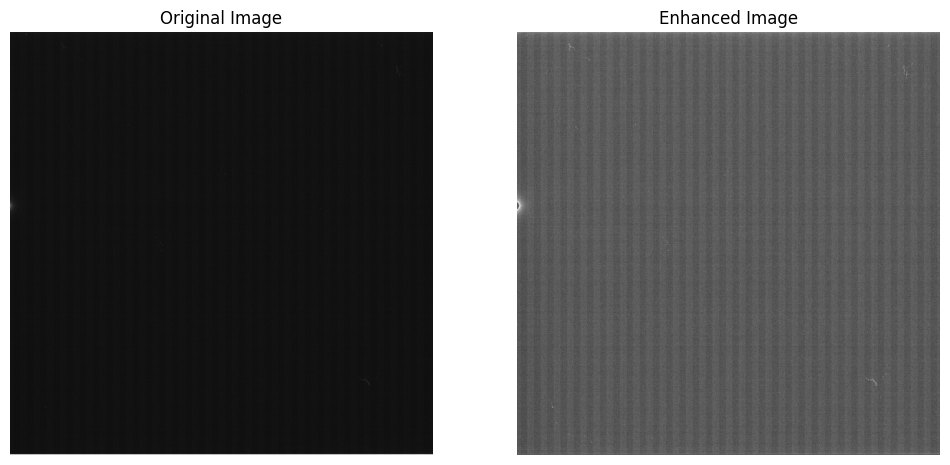

In [41]:
showcontrast('camera/0001.tif',2000)

1754.5469312667847


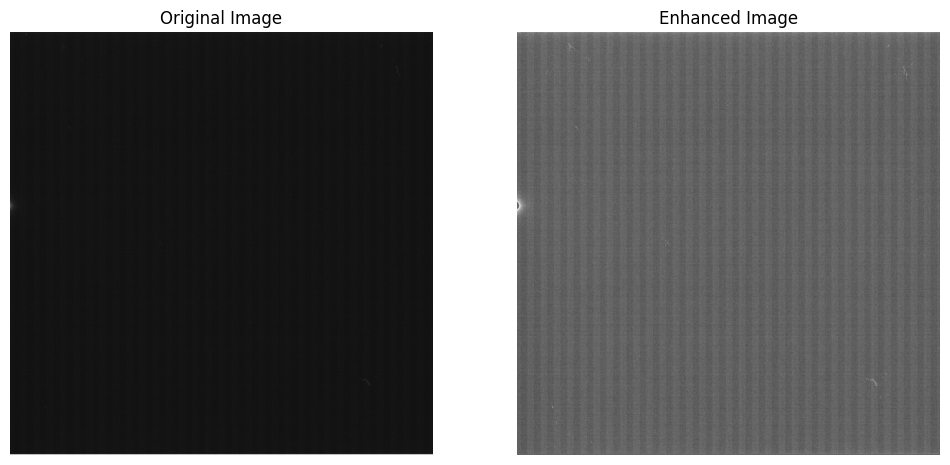

In [42]:
showcontrast('camera/output_image_T.tif',2000)

In [10]:
folder_path = 'camera/BLE'
files = os.listdir(folder_path)
images = []
for file in files:
    img_path = os.path.join(folder_path, file)
    img = Image.open(img_path)
    img_array = np.array(img)
    print(f"{file}:{img_array.mean(axis=(0, 1))}")

10_1.tif:1726.292221069336
10_2.tif:1726.1008949279785
10_3.tif:1723.0992050170898
10_4.tif:1716.764747619629
10_5.tif:1711.336009979248
10_6.tif:1711.2378311157227
10_7.tif:1711.6481590270996
1280_1.tif:2130.9018630981445
160_1.tif:1773.1581954956055
20_1.tif:1727.1941032409668
2560_1.tif:2524.5962829589844
320_1.tif:1825.4304313659668
40_1.tif:1733.207347869873
5_1.tif:1725.616054534912
5_2.tif:1725.562313079834
5_3.tif:1722.5282516479492
5_4.tif:1716.1035461425781
5_5.tif:1710.357334136963
5_6.tif:1710.1850395202637
5_7.tif:1710.1483192443848
640_1.tif:1928.1906089782715
80_1.tif:1746.5864067077637


In [12]:
import os
import re
from PIL import Image
import numpy as np
import openpyxl

def calculate_average_pixel_value(image_path):
    """ 计算图片像素的平均值 """
    with Image.open(image_path) as img:
        img_array = np.array(img)
        return np.mean(img_array)

def get_coordinates_from_filename(filename):
    """ 从文件名中提取坐标 """
    match = re.match(r'(\d+)_(\d+)', filename)
    if match:
        return int(match.group(1)), int(match.group(2))
    return None, None

def process_images(folder_path):
    """ 处理指定文件夹中的所有图片 """
    wb = openpyxl.Workbook()
    ws = wb.active

    # 收集所有的曝光时间和增益系数
    exposures = set()
    gains = set()
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')):
            exposure, gain = get_coordinates_from_filename(filename)
            if exposure is not None and gain is not None:
                exposures.add(exposure)
                gains.add(gain)

    # 排序
    sorted_exposures = sorted(exposures)
    sorted_gains = sorted(gains)

    # 在Excel中创建标题行和列
    for i, exposure in enumerate(sorted_exposures, start=2):
        ws.cell(row=1, column=i, value=exposure)
    for i, gain in enumerate(sorted_gains, start=2):
        ws.cell(row=i, column=1, value=gain)

    # 填充数据
    for filename in os.listdir(folder_path):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp')):
            exposure, gain = get_coordinates_from_filename(filename)
            if exposure is not None and gain is not None:
                avg_pixel_value = calculate_average_pixel_value(os.path.join(folder_path, filename))
                exposure_index = sorted_exposures.index(exposure) + 2
                gain_index = sorted_gains.index(gain) + 2
                ws.cell(row=gain_index, column=exposure_index, value=avg_pixel_value)

    wb.save('output.xlsx')

# 替换为您的图片文件夹路径
folder_path = 'camera/autoBLE'
process_images(folder_path)


In [4]:
import json
import openpyxl
from scipy.stats import linregress

def fit_linear_model_to_data_and_save(excel_file):
    wb = openpyxl.load_workbook(excel_file)
    ws = wb.active
    exposure_times = [cell.value for cell in ws[1] if cell.value is not None]
    print(exposure_times)

    # 准备存储斜率和截距
    last_column = ws.max_column
    ws.cell(row=1, column=last_column + 1, value="Slope (k)")
    ws.cell(row=1, column=last_column + 2, value="Intercept (b)")

    iso_params = {}

    for row_index, row in enumerate(ws.iter_rows(min_row=2, max_row=ws.max_row, min_col=1, max_col=1), start=2):
        gain = row[0].value
        if gain is not None:
            pixel_values = [ws.cell(row=row_index, column=i+2).value for i in range(len(exposure_times))]
            slope, intercept, _, _, _ = linregress(exposure_times, pixel_values)
            ws.cell(row=row_index, column=last_column + 1, value=slope)
            ws.cell(row=row_index, column=last_column + 2, value=intercept)
            print(type(gain))
            iso_params[gain] = {'slope': slope, 'intercept': intercept}

    # 保存修改后的Excel文件
    wb.save('fitted_output.xlsx')

    # 保存为JSON文件
    with open('iso_params.json', 'w') as f:
        json.dump(iso_params, f, indent=4, sort_keys=True)

excel_file = 'output.xlsx'
fit_linear_model_to_data_and_save(excel_file)


[100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000]
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>
<class 'int'>


In [21]:
def read_iso_params_from_json(json_file):
    with open(json_file, 'r') as f:
        iso_params = json.load(f)
    return iso_params

def calculate_pixel_value(iso, exposure_time, iso_params):
    if iso in iso_params:
        slope = iso_params[iso]['slope']
        intercept = iso_params[iso]['intercept']
        return slope * exposure_time + intercept
    else:
        return None

# 使用示例
iso_params = read_iso_params_from_json(json_file)
iso = "100"  # 替换为所需的ISO值
exposure_time = 1600000  # 替换为所需的曝光时间
average_pixel_value = calculate_pixel_value(iso, exposure_time, iso_params)
print(average_pixel_value)

2262.2339536861705


In [2]:
import os
import glob
import numpy as np
from PIL import Image
import json

def read_images(folder_path, exposure_time, iso_params):
    images = glob.glob(os.path.join(folder_path, '*.tif'))
    iso_values = []
    image_stack = []

    for image_path in images:
        iso_value = int(image_path.split('_')[-1].split('.')[0])
        img = Image.open(image_path)
        img_matrix = np.array(img)

        # 减去基线曝光
        ble = calculate_pixel_value(iso_value, exposure_time, iso_params)
        if ble is not None:
            img_matrix = img_matrix - ble

        iso_values.append(iso_value)
        image_stack.append(img_matrix)

    return np.array(iso_values), np.stack(image_stack, axis=-1)

def linear_fit(iso_values, image_stack):
    x = iso_values
    x_mean = x.mean()
    # 添加一个新维度，使形状变为 (2048, 2048, 1)
    y_mean = image_stack.mean(axis=-1)[:, :, np.newaxis]
    ss_xy = np.tensordot((x - x_mean), (image_stack - y_mean), axes=([0], [2]))
    ss_xx = np.sum((x - x_mean) ** 2)

    K_matrix = ss_xy / ss_xx
    # 扩展 K_matrix 的形状到 (2048, 2048, 1) 以匹配 y_mean
    K_matrix_expanded = K_matrix[:, :, np.newaxis]

    B_matrix = y_mean - K_matrix_expanded  * x_mean
    B_matrix = B_matrix.squeeze()

    return K_matrix, B_matrix

def save_matrices(K_matrix, B_matrix, k_matrix_path = 'K_matrix.npy', b_matrix_path = 'B_matrix.npy'):
    np.save( k_matrix_path, K_matrix)
    np.save( b_matrix_path, B_matrix)

def load_matrices(k_matrix_path = 'K_matrix.npy', b_matrix_path = 'B_matrix.npy'):
    K_matrix = np.load(k_matrix_path)
    B_matrix = np.load(b_matrix_path)
    return K_matrix, B_matrix


def read_iso_params_from_json(json_file = 'iso_params.json'):
    with open(json_file, 'r') as f:
        iso_params = json.load(f)
    return iso_params

#计算对应曝光时间和ISO下的BLE
def calculate_pixel_value(iso, exposure_time, iso_params):
    if iso in iso_params:
        slope = iso_params[iso]['slope']
        intercept = iso_params[iso]['intercept']
        return slope * exposure_time + intercept
    else:
        return None

# 使用示例
folder_path = 'camera/autoFPN'
iso_params = read_iso_params_from_json('iso_params.json') 
iso_values, image_stack = read_images(folder_path,100000,iso_params)
K_matrix, B_matrix = linear_fit(iso_values, image_stack)
save_matrices(K_matrix, B_matrix)
K_matrix, B_matrix  = load_matrices()
print(type(K_matrix))
print(K_matrix.shape)
print(type(B_matrix))
print(B_matrix.shape)


<class 'numpy.ndarray'>
(2048, 2048)
<class 'numpy.ndarray'>
(2048, 2048)
